# 投票分类器 Voting Classifiers

要创建出一个更好的分类器最简单的办法就是聚合每一个分类器的预测，然后将得票数最多的结果，作为预测类别。这种大多数投票分类器被称为`硬投票分类器`

<img src="../images/other/7-1.png" width="400">

<img src="../images/other/7-2.png" width="400">

这个投票分类器的准确率通常比集成中最好分类器还要高一些。事实上，即使每个分类器都是弱学习器，通过集成，依旧可以实现一个强学习器，只要有足够大数量并且足够多种类的弱学习器即可。

    1. 以卫星数据集为例，创建并训练一个硬投票分类器

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [3]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)

In [4]:
X_train.shape, X_test.shape

((375, 2), (125, 2))

- `Scikit-Learn`的`VotingClassifier()`创建投票分类器

In [5]:
from sklearn.ensemble import VotingClassifier

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [7]:
# 弱分类器
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
log_model = LogisticRegression(solver='lbfgs', random_state=42)
svm_model = SVC(gamma="scale", random_state=42)

In [8]:
# 硬投票分类器
hard_voting_model = VotingClassifier(
                estimators=[('RandomForest', rf_model), ('LogisticRegression', log_model), ('SVC', svm_model)],
                voting='hard'
             )

In [9]:
# 查看测试集上每个分类器的精度
from sklearn.metrics import accuracy_score

models = [rf_model, log_model, svm_model, hard_voting_model]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(model.__class__.__name__, score)

RandomForestClassifier 0.904
LogisticRegression 0.848
SVC 0.928
VotingClassifier 0.92


如果所有分类器能够估算出类别的概率(即有`predict_proba()`方法)，那么你可以将概率在所有单个分类器上平均,然后让`Scikit-Learn`计算平均概率最高的类别进行预测，这被称为`软投票法`。通常来说，它比`硬投票法`表现更优，因为他给予了那些高度自信投票更高的权重。

    2. 以卫星数据集为例，创建并训练一个软投票分类器

In [10]:
# 弱分类器
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
log_model = LogisticRegression(solver='lbfgs', random_state=42)
svm_model = SVC(gamma="scale", random_state=42, probability=True) # 会添加predict_proba(), predict_log_proba()两个方法

In [11]:
# 软投票分类器
soft_voting_model = VotingClassifier(
                estimators=[('RandomForest', rf_model), ('LogisticRegression', log_model), ('SVC', svm_model)],
                voting='soft'
            )

In [12]:
# 查看测试集上每个分类器的精度
models = [rf_model, log_model, svm_model, soft_voting_model]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(model.__class__.__name__, score)

RandomForestClassifier 0.904
LogisticRegression 0.848
SVC 0.928
VotingClassifier 0.904


# Bagging 和 Pasting

获取不同种类分类器的方法除了使用不同的训练算法，另一种方法是每一个预测其使用相同的算法，但是在不同的训练集随机子集上进行训练，如果采样时将样本放回，这种方法叫`Bagging`,如采用时样本不放回这种方法叫做`Pasting`.

<img src="../images/other/7-3.png" width="400">

一旦预测器训练完成，集成就可以通过简单的聚合所有预测器的预测来对新实例作出预测。每个预测器单独的偏差都高于原始训练集上训练的偏差，但通过聚合同时降低了偏差和方差。总体来说，最终结果是与 直接在原始训练集上训练的单个去预测器 相比集成的偏差相近，但方差更低。

## Scikit-Learn 中的 Bagging 和 Pasting  

    训练一个包括500个决策树的分类器的集成，每次从训练集中随机采样100个训练实例进行训练，然后放回。

- `Scikit-Learn`的`BaggingClassifier()`进行Bagging 和 Pasting

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
bagging_model = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,  # 采用时样本放回 如果不放回就是pasting
    n_jobs=-1)
bagging_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1)

In [15]:
y_pred = bagging_model.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.92

In [16]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.864

如果基本分类器能够估算出类别的概率(即有`predict_proba()`方法)，则`BaggingClassifier()`自动执行`软投票法`

- 比较决策边界

In [17]:
from matplotlib.colors import ListedColormap  # 用户自定义颜色库


def plot_decision_boundary(model, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)  # 生成网格点坐标矩阵   (100, 100)

    X_new = np.c_[x1.ravel(), x2.ravel()]  # (10000, 2)
    y_pred = model.predict(X_new).reshape(x1.shape)  # (100, 100)

    custome_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

    # 绘制等高线图
    plt.contourf(x1, x2, y_pred, cmap=custome_cmap)

    # 数据
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=0.5)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=0.5)
    plt.axis(axes)

In [18]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='../Fonts/SourceHanSerifSC-Medium.otf', size=12)

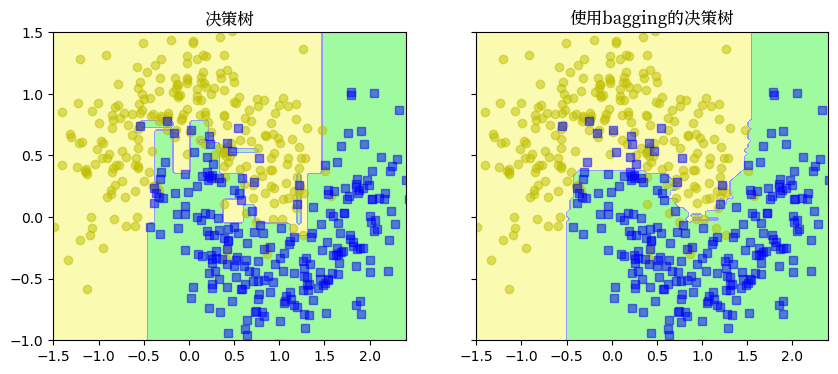

In [19]:
fix, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
ax = [-1.5, 2.4, -1, 1.5]

plt.sca(axes[0])
plot_decision_boundary(tree_model, X, y, ax)
plt.title("决策树", font_properties=my_font)

plt.sca(axes[1])
plot_decision_boundary(bagging_model, X, y, ax)
plt.title("使用bagging的决策树", font_properties=my_font)

plt.show()

由此看出，集成预测的泛化效果可能比单独的决策树要好一些。两者偏差相近，但集成的方差更小:两边训练集的错误数量差不多，但集成的决策边界更规则。

## 包外评估 Out-of-Bag Evaluation

对于任意给定的预测器,使用`bagging`,有些实例可能会被采样多次,而有些实例则可能根本不被采样。`BaggingClassifier`默认采样$m$个训练实例,然后放回样本(`bootstrap=true`),$m$是训练集的大小.

这意味着对每个预测器来说,平均只对65%的训练实例进行采样。剩余37%未被采样的训练实例称为`包外oob实例`。注意, 对所有预测器来说,这是不一样的37%.

由于预测器在训练过程中从未看到`oob实例`,因此可以在这些实例上进行评估,而无须单独的验证集。你可以通过平均每个预测器的`包外评估`来评估整体。

- 在`Scikit-learn`中,创建 `BaggingClassifier`时,设置`oob_score=True`就可以请求在训练结束后自动进行`包外评估`

In [20]:
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                  n_estimators=500,
                                  max_samples=100,
                                  bootstrap=True,
                                  random_state=42,
                                  oob_score=True)
bagging_model.fit(X_train, y_train)
bagging_model.oob_score_

0.9146666666666666

In [21]:
y_pred = bagging_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

可知`包外评估结果`与测试集上的所获得的准确率相接近

In [22]:
bagging_model.oob_decision_function_[0]

array([0.05929919, 0.94070081])

可以通过`oob_decision_function_`获取包外决策函数，如第一个训练实例有5.9%的概率是正类，而有94.1%的概率为负类.

# 随机补丁和随机子空间 Random Patches and Random Subspaces

`BaggingClassifier`类也支持对特征进行采样。采样由两个超参数控制:`max_features`和 `bootstrap_features`。它们的工作方式与`max_samples`和 `bootstrap` 相同,但用于特征采样而不是实例采样。因此,每个预测器将用**输入特征的随机子集**进行训练.

这对于处理高维输入(例如图像)特别有用。
1. 对训练实例和特征都进行抽样,这称为**随机补丁法**。
2. 保留所有训练实例(即 `bootstrap= False`并且 `max_samples=1`)但是对特征进行抽样(即 `bootstrap_features=True`并且/或 `max_features<1` 这被称为**随机子空间法**。

对特征抽样给预测器带来更大的多样性,所以以略高一点的偏差换取了更低的方差

# 随机森林 Random Forests

随机森林是决策树的集成,训练方法:
1. 构建一个`BaggingClassifier`然后将其传输到 `DecisionTreeClassifier`来设置,训练集大小设置`max_samples=1.0`
2. 使用 `RandomForestClassifier`类,这种方法更方便,对决策树更优化。

    训练了一个拥有500棵树的随机森林分类器(每棵树限制为最多16个叶节点)

In [23]:
# 使用方法1:
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(
    max_leaf_nodes=16, splitter="random"),
                                  n_estimators=500,
                                  max_samples=1.0,
                                  random_state=42,
                                  bootstrap=True)
bagging_model.fit(X_train, y_train)

y_pred_bagging = rf_model.predict(X_test)
accuracy_score(y_test, y_pred_bagging)

0.904

- `Scikit-Learn`的`RandomForestClassifier()`类创建随机森林分类器

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
# 使用方法2:
rf_model = RandomForestClassifier(
                n_estimators=500,
                max_leaf_nodes=16,
                random_state=42
            )
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.92

具体来说，`RandomForestClassifier`对比`DecisionTreeClassifier`和`BaggingClassifier`的超参数有以下的区别:
1. 没有`splitter`:特征选择随机选项(强制为`random`)
2. 没有`presort`:预排序(强制为`False`)
3. 没有`max_samples`(强制为`1.0`)
4. 没有`base_estimator`(给定为`DecisionTreeClassifier()`)

随机森林在树的生长上引入了更多的随机性:分裂节点时不再是搜素最好的特征,而是在一个随机生成的特征子集里搜索最好的特征。这导致决策树具有更大的多样性,(再一次)用更高的偏差换取更低的方差,总之,还是产生了一个整体性能更优的模型。

## 极端随机树 Extra-Trees

随机森林里单棵树的生长过程中,每个节点在分裂时仅考虑到了一个随机子集所包含的特征,如果我们对每个特征使用`随机阈值`,而不是搜索得出的最佳值阈值,则可能让决策树生长得更加随机.

这种极端随机的决策树组成的森林称为`极端随机树集成 Ertra-Tree`。同样，它也是以更高的偏差换取了更低的方差。`极端随机树`训练起来比常规随机森林要快很多,因为在每个节点上找到每个特征的最佳阈值是决策树生长中最耗时的任务之一.


- `Scikit-Learn`的`ExtraTreesClassifier()`类创建极端随机树分类器

通常来说,很难预先知道一个 `RandomForestClassifier`类是否会比一个`ExtraTreesClassifier()`类更好或是更差。唯一的方法是两种都尝试,然后使用`交叉验证`(还需要使用网格搜素调整超参数)进行比较.

## 特征重要性 Feature Importance

随机森林的另一个好特性是它们使测量每个特征的相对重要性变得容易。`Scikit-Learn`通过查看使用该特征的树节点平均(在森林中的所有树上)减少不纯度的程度来衡量该特征的重要性。


`Scikit-Learn`会在训练后为每个特征自动计算该分数,然后对结果进行缩放以使所有重要性的总和等于1。可以使用 `feature_importances_`变量来访问结果。


    1. 以鸢尾花数据集为例

In [26]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_X = iris['data']
iris_y = iris['target']

rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(iris_X, iris_y)

#特征重要性
scores = rf_model.feature_importances_
scores

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [27]:
for feature, score in zip(iris['feature_names'], scores):
    print(feature,score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


由此可见最重要的特征是花瓣的长度(44.1%)和宽度(42.3%)和花萼的长度(11.2%)和宽度(2.3%)则不是那么重要.

    2. 以MNIST数据集为例

In [28]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
X_mnist = mnist['data'].astype(np.float32)
y_mnist = mnist['target'].astype(np.uint8)

In [29]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_mnist, y_mnist)

RandomForestClassifier(random_state=42)

In [30]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28,28)
    plt.matshow(image, cmap=mpl.cm.hot)
    plt.axis("off")

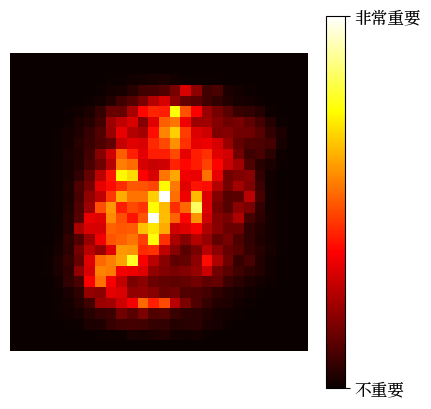

In [31]:
# 绘制出根据随机森林分类器的MNIST像素的重要性
plot_digit(rf_model.feature_importances_)

cbar = plt.colorbar(ticks=[
    rf_model.feature_importances_.min(),
    rf_model.feature_importances_.max()
])
cbar.ax.set_yticklabels(['不重要', '非常重要'], fontproperties=my_font)
plt.show()

随机森林非常便于你快速了解，哪些特征是真正重要的，特别是在执行特征选择时.

# 提升法 Boosting

## AdaBoost

`AdaBoost`是一种具有自适应性质的`Boosting`集成学习算法.自适应性主要表现在自动提升被错误预测样本的权重,自动减少被正确预测样本的权重,使得弱学习器训练过程能够根据模型预测性能自动进行调整.

<img src="../images/other/7-4.png" width="400">

----
**AdaBoost算法：**

① 令 $i=1$ 并设定弱学习器的数目 $m$ 。使用均匀分布初始化训练样本集的权重分布, 令 $n$ 维向量 $w^{i}$ 表示第 $i$ 次需更新的样本权重, 则有: $$w^{1}=\left(w_{i 1}, w_{i 2}, \cdots, w_{i n}\right)^{T}=\left(\frac{1}{n}, \frac{1}{n}, \cdots, \frac{1}{n}\right)^{T}$$

②使用权重分布为 $w^{i}$ 的训练样本集 $D_{i}$ 学习得到第 $i$ 个弱学习器 $f_{i}$

③计算 $f_{i}$ 在训练样本集 $D_{i}$ 上的分类错误率 $e_{i}$ :
$$
e_{i}=\sum_{k=1}^{n} w_{i k} I\left(f_{i}\left(X_{k}\right) \neq y_{k}\right)
$$

④ 确定弱学习器 $f_{i}$ 的组合权重 $\alpha_{i}$ 由于弱学习器 $f_{i}$ 的
     权重取值应与其分类性能 相关, 对于分类错误率 $e_{i}$ 越小的 $f_{i}$, 
     则其权重 $\alpha_{i}$ 应该越大，故有 
$$\alpha_{i}=\lambda \ln \frac{1-e_{i}}{e_{i}}$$

⑤ 依据弱学习器 $f_{i}$ 对训练样本集 $D_{i}$ 的分类错误率 $e_{i}$ 更新样本权重, 更新公式为 $$w_{i+1, j}=\frac{w_{i j} \exp \left(-\alpha_{i} y_{k} f_{i}\left(X_{k}\right)\right)}{z_{i}}$$其中归一化因子: $$Z_{i}=\sum_{k=1}^{n} w_{i j} \exp \left(-\alpha_{i} y_{k} f_{i}\left(X_{k}\right)\right)$$ 保证更新后权重向量为概率分布

⑥ 若 $i<m$, 则令 $i=i+1$ 并返回步骤（2）, 否则执行步骤 (7)

⑦ 对于 $m$ 个弱分类器 $f_{1}, f_{2}, \cdots, f_{m}$, 分别将每个 $f_{i}$ 按权重 $\alpha_{i}$ 进行组合: $$G=\operatorname{sign}\left(\sum_{i=1}^{m} \alpha_{i} f_{i}(X)\right)$$得到并输出所求集成模型 $G$, 算法结束

---

不改变训练数据而不断地改变训练数据权值的分布，使得训练数据在基学习器的学习中物体起不同的作用，就是`AdaBoost`的一个特点。



- `Scikit- Learn`使用的其实是`AdaBoost`的一个多分类版本,叫作`SAMME`(基于多类指数损失函数的逐步添加模型),当只有两类时,`SAME`即等同于`Adaboost`.

- 此外,如果预测器可以估算类概率(即具有`predict_proba()`方法), `Scikit- Learn`会使用`SAMME`的变体,称为 `SAMME.R`(R代表“Real”),它依赖的是类概率而不是类预测,通常表现更好。

    训练了一个 Adaboost分类器:基于200个单层决策树(max_depth=1的决策树,默认使用的基础估算器)

- `Scikit-Learn`的`AdaBoostClassifier()`类创建AdaBoost分类器

In [32]:
from sklearn.ensemble import AdaBoostClassifier

In [33]:
ab_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm='SAMME.R',
    learning_rate=0.5,  # 𝜆
    random_state=42)
ab_model.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

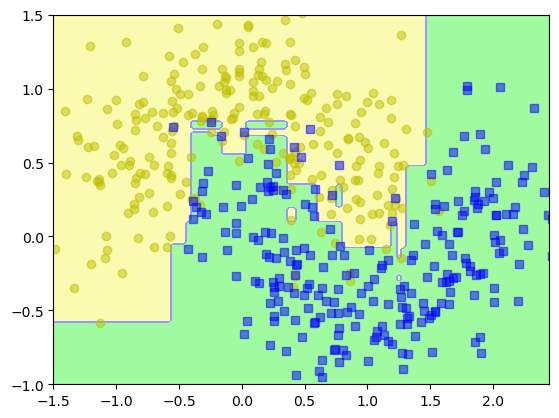

In [34]:
ax = [-1.5, 2.45, -1, 1.5]
plot_decision_boundary(ab_model, X, y, ax)

如果你的`AdaBoost`集成过度拟合训练集，可以试试减少估算器数量或者提高基础估算器的正则化程度

## 梯度提升 Gradient Boosting

与`AdaBoost`不同的是，`梯度提升`是让新的预测器针对前一个预测器的残差进行拟合.

----

**梯度提升算法：**

输入: 训练数据集 $T=\left\{\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \cdots,\left(x_{N}, y_{N}\right)\right\}, x_{i} \in \mathcal{X} \subseteq \mathbf{R}^{n}, y_{i} \in \mathcal{Y} \subseteq \mathbf{R}$;损失函数 $L(y, f(x))$; 

输出：回归树 $\hat{f}(x)$.

①  初始化
$$
f_{0}(x)=\arg \min _{c} \sum_{i=1}^{N} L\left(y_{i}, c\right)
$$

② 对 $m=1,2, \cdots, M$
(1) 对 $i=1,2, \cdots, N$, 计算
$$
r_{m i}=-\left[\frac{\partial L\left(y_{i}, f\left(x_{i}\right)\right)}{\partial f\left(x_{i}\right)}\right]_{f(x)=f_{m-1}(x)}
$$

(2) 对 $r_{m i}$ 拟合一个回归树，得到第 $m$ 棵树的叶结点区域 $R_{m}, j=1,2, \cdots, J$

(3) 对 $j=1,2, \cdots, J$, 计算
$$
c_{m j}=\arg \min _{c} \sum_{x_{i} \in R_{m}} L\left(y_{i}, f_{m-1}\left(x_{i}\right)+c\right)
$$

(4) 更新 $f_{m}(x)=f_{m-1}(x)+\sum_{j=1}^{J} c_{m j} I\left(x \in R_{m j}\right)$

③ 得到回归树
$$
\hat{f}(x)=f_{M}(x)=\sum_{m=1}^{M} \sum_{j=1}^{J} c_{m j} I\left(x \in R_{m j}\right)
$$

----

使用决策树作为基础预测器，这被称为`梯度树提升`或者是`梯度提升回归树GBRT`.
在回归问题中，这称为`梯度提升回归树GBRT`，分类问题则称为`梯度提升决策树GBDT`.

    以一个简单的回归为例

1. 生成一个带噪音的二次训练集

In [35]:
np.random.seed(42)
X = np.array(np.random.rand(100,1) - 0.5)
y = np.array(3*(X[:, 0]**2) + 0.05 * np.random.randn(100))

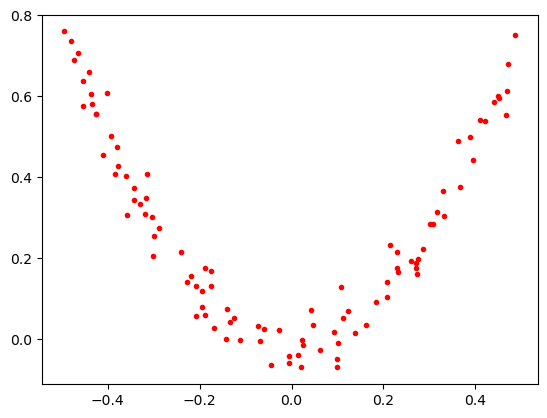

In [36]:
plt.plot(X, y, 'r.')
plt.show()

2. 首先拟合一个决策树模型

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_model_1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_model_1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

3. 针对第一个预测器的残差 训练第二个决策树模型

In [38]:
y2 = y - tree_model_1.predict(X)  # 残差

tree_model_2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_model_2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

3. 针对第二个预测器的残差 训练第三个决策树模型

In [39]:
y3 = y2 - tree_model_2.predict(X)  # 残差

tree_model_3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_model_3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

4. 集成三棵树:将所有树的预测相加，并对新实例进行预测

In [40]:
X_new = np.array([[0.8]])

In [41]:
y_pred = sum(tree.predict(X_new) for tree in (tree_model_1, tree_model_2, tree_model_3))
y_pred

array([0.75026781])

<img src="../images/other/7-5.png" width="600">

- `Scikit-Learn`的`GradientBoostingRegressor()`类创建GBRT集成分类器

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

In [43]:
gbrt_model = GradientBoostingRegressor(
                max_depth=2,
                n_estimators=3,
                learning_rate=1.0,
                random_state=42
            )
gbrt_model.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

超参数`learning_rate`对每棵树的贡献进行缩放。如果你已经设置为低值(如0.1)，则需要更多的树来拟合数据集。但预测的泛化效果通常更好，这是一种被称为`收缩的正则化`技术。

In [44]:
gbrt_model_lr = GradientBoostingRegressor(max_depth=2,
                                          n_estimators=200,
                                          learning_rate=0.1,
                                          random_state=42)
gbrt_model_lr.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [45]:
def plot_predictions(model, X, y, axes):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1,1)
    y_pred = model.predict(x1)
    plt.plot(X[:, 0], y, 'b.')
    plt.plot(x1, y_pred, 'r-')
    #plt.axis(axes)

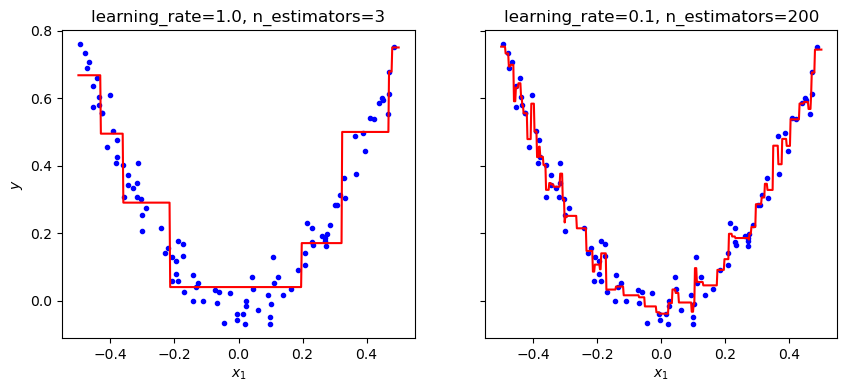

In [46]:
fix, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
ax = [-0.5, 0.5, -0.1, 0.8]

plt.sca(axes[0])
plot_predictions(gbrt_model, X, y, ax)
plt.xlabel('$x_1$')
plt.ylabel('$y$')
plt.title("learning_rate={}, n_estimators={}".format(gbrt_model.learning_rate,
                                                     gbrt_model.n_estimators))

plt.sca(axes[1])
plot_predictions(gbrt_model_lr, X, y, ax)
plt.xlabel('$x_1$')
plt.title("learning_rate={}, n_estimators={}".format(
    gbrt_model_lr.learning_rate, gbrt_model_lr.n_estimators))

plt.show()

左图显示预测器太少欠拟合，右图显示预测器太多过拟合.

### 提前停止法 Early stopping

- 要找到树的最佳数量`n_estimators`可以使用`提前停止法`.

1. 使用`staged_predict()`方法:在训练的每一阶段(一棵树,两棵树,三棵树时等),都对集成的预测返回一个迭代器。

     训练一个拥有120棵树的GBRT集成，然后测量每个训练阶段的验证误差，从而找到树的最佳数量，最后使用最优树数重新训练一个GBRT集成

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# 训练模型
gbrt_model = GradientBoostingRegressor(max_depth=2,
                                       n_estimators=120,
                                       random_state=42)
gbrt_model.fit(X_train, y_train)

# 计算MSE
errors = []
for y_pred in gbrt_model.staged_predict(X_val):
    mse = mean_squared_error(y_true=y_val, y_pred=y_pred)
    errors.append(mse)

# 选择MSE最低的树数作为树的最佳数量
min_error = np.min(errors)
best_n_estimators = np.argmin(errors) + 1

# 使用最优树数重新训练一个GBRT集成
gbrt_model_best = GradientBoostingRegressor(max_depth=2,
                                            n_estimators=best_n_estimators,
                                            random_state=42)
gbrt_model_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

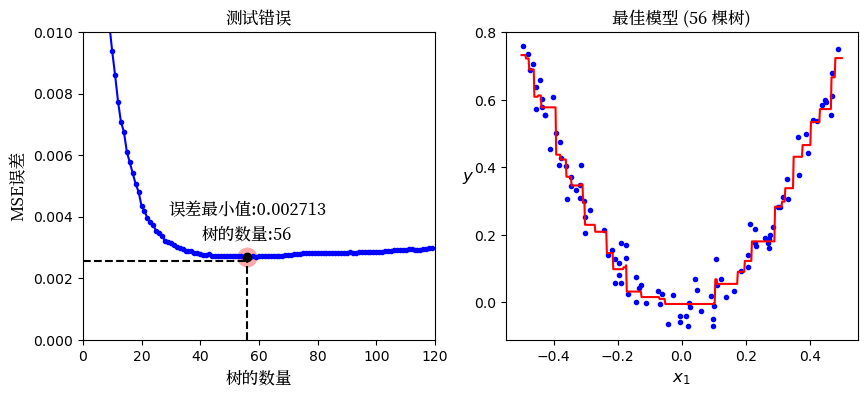

In [49]:
fix, axes = plt.subplots(ncols=2, figsize=(10, 4))

# 测试集错误
plt.sca(axes[0])
plt.plot(errors, "b.-")

plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, best_n_estimators], [min_error * 0.95, min_error * 0.95], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.scatter(best_n_estimators, min_error, s=180, facecolors='#FFAAAA')
plt.text(x=best_n_estimators,
         y=min_error * 1.5,
         s="误差最小值:%f" % min_error,
         ha="center",
         fontproperties=my_font)
plt.text(x=best_n_estimators,
         y=min_error * 1.2,
         s="树的数量:%d" % best_n_estimators,
         ha="center",
         fontproperties=my_font)

plt.xlabel("树的数量", fontproperties=my_font)
plt.ylabel("MSE误差", fontproperties=my_font)
plt.title("测试错误", fontproperties=my_font)
plt.axis([0, 120, 0, 0.01])

# 最佳模型
plt.sca(axes[1])
ax = [-0.5, 0.5, -0.1, 0.8]
plot_predictions(gbrt_model_best, X, y, ax)
plt.title("最佳模型 (%d 棵树)" % best_n_estimators, fontproperties=my_font)
plt.ylabel("$y$", rotation=0, fontproperties=my_font)
plt.xlabel("$x_1$", fontproperties=my_font)

plt.show()

2. 要实现`提前停止法`，不一定要训练大量的树，然后再回头来找最优的数字，还可以`提前停止训练`:设置`warm_start=True`，当`fit()`方法被调用时，`Scikit-Learn`会保留现有的树，从而允许增量训练.

    当验证误差连续5次迭代未得到改善，直接停止训练

In [50]:
gbrt_model = GradientBoostingRegressor(max_depth=2,
                                       warm_start=True,
                                       random_state=42)

min_error = float("inf")
n_iter = 0  # 用于限制迭代次数 实现提前停止训练

for n_estimators in range(1, 120):
    gbrt_model.n_estimators = n_estimators
    gbrt_model.fit(X_train, y_train)

    y_pred = gbrt_model.predict(X_val)
    error = mean_squared_error(y_pred=y_pred, y_true=y_val)

    if error < min_error:
        min_error = error
        n_iter = 0
    else:
        n_iter += 1
        if n_iter == 5:
            break  # 提前停止训练

In [51]:
gbrt_model.n_estimators - 5

56

In [52]:
min_error

0.002712853325235463

`GradientBoostingRegressor()`的超参数`subsample`,指定用于训练每棵树的实例的比例。这也是用更高的偏差换取了更低的方差，同时加速了训练过程，这种技术被称为`随机梯度提升`

### XGBoost

In [53]:
import xgboost

In [54]:
xgb_model = xgboost.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)
error = mean_squared_error(y_pred=y_pred, y_true=y_val)
print("Validation MSE:", error) 

Validation MSE: 0.004000408205406276


In [55]:
# 实现自动处理提前停止
xgb_model.fit(X_train,
              y_train,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=2)
y_pred = xgb_model.predict(X_val)
error = mean_squared_error(y_pred=y_pred, y_true=y_val)
print("Validation MSE:", error)

/home/sora/anaconda3/envs/DL/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


# 堆叠法 Stacking

`堆叠法stacking`,又称`层叠泛化法`。它是基于一个简单的想法:与其使用一些简单的函数(比如硬投票)来聚合集成中所有预测器的预测,我们为什么不训练一个模型来执行这个聚合呢?

<img src="../images/other/7-6.png" width="400">

底部的三个预测器分别预测了不同的值(3.1,2.7和2.9),然后最终的预测器(称为`混合器`或`元学习器`)将这些预测作为输入,进行最终预测(3.0).

调练`混合器`的常用方法是使用`留存集`。我们看看它是如何工作的。

1. 首先,将训练集分为两个子集,第一个子集用来训练第一层的预测器

<img src="../images/other/7-7.png" width="400">

2. 然后,用第一层的预测器在第二个(留存)子集上进行预测,因为预测器在训练时从未见过这些实例,所以可以确保预测是“干净的”.

<img src="../images/other/7-8.png" width="400">

3. 那么现在对于留存集中的每个实例都有了三个预测值。我们可以使用这些预测值作为输入特征,创建一个新的训练集(新的训练集有三个维度),并保留目标值。在这个新的训练集上训练混合器,让它学习根据第一层的预测来预测目标值。

4. 事实上,通过这种方法可以训练多种不同的混合器(例如,一个使用线性回归、另一个使用随机森林回归,等等)。于是我们可以得到一个混合器层。

诀窍在于在于将训练集分为三个子集:
- 第一个:训练第一层
- 第二个:用来创造训练第二层的新训练集(使用第一层的预测)
- 第三个:用来创造训练第三层的新训练集(使用第二员的预测)

一旦训练完成,我们可以按照顺序遍历每层来对新实例进行预测

<img src="../images/other/7-9.png" width="400">

# 练习题 Exercise

## ex.1

Q:如果你已经在完全相同的训练集上训练了5个不同的模型,并且它们都达到了95%的准确率,是否还有机会通过结合这些模型来获得更好的结果?如果可以,该怎么做?如果不行,为什么?

>If you have trained five different models and they all achieve 95% precision, **you can try combining them into a voting ensemble, which will often give you even better results.** It works better if **the models are very different** (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are **trained on different training instances** (that’s the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.

## ex.2

Q:硬投票分类器和软投票分类器有什么区别?

>**A hard voting classifier** just counts the votes of each classifier in the ensemble and **picks the class that gets the most votes.** **A soft voting classifier** computes the average estimated class probability for each class and **picks the class with the highest probability.** This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set `probability=True`).

## ex.3

Q:是否可以通过在多个服务器上并行来加速`bagging集成`的训练? `pasting集成`呢?`boosting集成`呢?`随机森林`或 `Stacking集成`呢?

>1. It is quite possible to **speed up** training of a **bagging ensemble** by distributing it across multiple servers, since each predictor in the ensemble is **independent of the others**. 
2. The **same** goes for **pasting ensembles** and **Random Forests**, for the same reason. 
3. However, each predictor in a **boosting ensemble** is built based on the previous predictor, so training is necessarily sequential, and you will **not gain anything** by distributing training across multiple servers. 
4. Regarding **stacking ensembles**, all the predictors in a given layer are independent of each other, so they **can be trained** in parallel on multiple servers. However, the predictors in one layer **can only be trained** after the predictors in the previous layer have all been trained.

## ex.4

Q:包外评估的好处是什么?

>With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were held out). This makes it possible to have a fairly unbiased evaluation of the ensemble **without the need for an additional validation set.** Thus, you have more instances available for training, and your ensemble can **perform slightly better.**

## ex.5

Q:是什么让极端随机树比一般随机森林更加随机?这部分增加的随机性有什么用?极端随机树比一般随机森林快还是慢?

>1. When you are growing a tree in a Random Forest, only a random subset(子集) of the features is considered for splitting at each node. This is true as well for **ExtraTrees**, but they go one step further: rather than searching for the best possible thresholds(最佳阈值), like regular Decision Trees do, they **use random thresholds for each feature.** 
2. This extra randomness acts like a form of **regularization**: if a Random Forest overfits the training data, Extra-Trees might perform better. 
3. Moreover, since Extra-Trees don’t search for the best possible thresholds, they are **much faster to train than Random Forests**. However, they are **neither faster nor slower than Random Forests when making predictions**.

## ex.6

Q:如果你的 Adaboost集成对训练数据欠拟合,你应该调整哪些超参数?怎么调整?

>If your AdaBoost ensemble underfits the training data, you can try **increasing the number of estimators** (`n_estimators`) or **reducing the regularization hyperparameters of the base estimator**(like `max_depth`). You may also try **slightly increasing the learning rate**.(`learning_rate`)

## ex.7

Q:如果你的梯度提升集成对训练集过拟合,你是应该提升还是降低学习率?

>If your Gradient Boosting ensemble overfits the training set, you should try **decreasing the learning rate.** You could also **use early stopping to find the right number of predictors** (you probably have too many).

## ex.8

Q:完成下面的任务
>1. 加载 MNIST数据集(第3章中有介绍),将其分为一个训练集、一个验证集和一个测试集(例如,使用50000个实例训练、10000个实例验证、10000个实例测试)。 
2. 训练多个分类器,比如一个随机森林分类器、一个极端随机树分类器、一个SVM分类器和一个神经网络分类器。
3. 尝试使用软投票法或者硬投票法将它们组合成一个集成,这个集成在验证集上的表现要胜过它们各自单独的表现。
4. 成功找到集成后,在测试集上测试。与单个的分类器相比,它的性能要好多少?


    1. Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing).

In [56]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)
X_mnist = mnist['data'].astype(np.float32)
y_mnist = mnist['target'].astype(np.uint8)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, 
                                                    test_size=10000, random_state=42)
# 从训练集中划分出验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=10000, random_state=42)

In [58]:
y_train.shape, y_val.shape, y_test.shape, 

((50000,), (10000,), (10000,))

    2. Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM.

In [59]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [60]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
extra_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_model = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_model = MLPClassifier(random_state=42)

In [61]:
estimators = [rf_model, extra_model, svm_model, mlp_model]

# 训练模型并打印各个弱分类器的评分
for estimator in estimators:
    estimator.fit(X_train, y_train)
    
    score = estimator.score(X_val, y_val)
    print(estimator.__class__,score)

<class 'sklearn.ensemble._forest.RandomForestClassifier'> 0.9692
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 0.9715
<class 'sklearn.svm._classes.LinearSVC'> 0.859
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> 0.9604


    3. Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier.

In [62]:
from sklearn.ensemble import VotingClassifier

In [63]:
models = [('RandomForestClassifier', rf_model),
          ('ExtraTreesClassifier', extra_model), ('LinearSVC', svm_model),
          ('MLPClassifier', mlp_model)]

In [64]:
voting_clf = VotingClassifier(estimators=models, voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('RandomForestClassifier',
                              RandomForestClassifier(random_state=42)),
                             ('ExtraTreesClassifier',
                              ExtraTreesClassifier(random_state=42)),
                             ('LinearSVC',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('MLPClassifier', MLPClassifier(random_state=42))])

In [65]:
voting_clf.score(X_val, y_val)

0.97

由于SVM预测器的评分器较低，我们在硬投票分分类器中尝试将其忽略.

In [66]:
voting_clf.set_params(LinearSVC=None)
voting_clf.estimators[2]

('LinearSVC', None)

In [67]:
voting_clf.estimators_[2]

LinearSVC(max_iter=100, random_state=42, tol=20)

虽然更新了估算器列表,但没有更新已训练的估算器列表.解决方法是可以重新训练,或者直接从已训练的估算器列表中移除.

In [68]:
del voting_clf.estimators_[2]
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 MLPClassifier(random_state=42)]

In [69]:
voting_clf.score(X_val, y_val)

0.9736

得到的结果优于添加了SVM的评分(0.9709)

In [70]:
voting_clf.voting = 'soft'
voting_clf.score(X_val, y_val)
voting_clf.score(X_val, y_val)

0.9687

无需重新训练预测器，也可以转换为`软投票法`,评分结果显示这种情况下`硬投票法`更优.

4. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

In [71]:
voting_clf.voting = 'hard'
voting_clf.score(X_test, y_test)

0.9694

In [72]:
for estimator in voting_clf.estimators_:
    score = estimator.score(X_test, y_test)
    print(estimator.__class__,score)

<class 'sklearn.ensemble._forest.RandomForestClassifier'> 0.9645
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 0.9691
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> 0.9574


在这种情况下，投票分类器仅略微略微降低了最佳模型的错误率。

## ex.9

Q:完成下面的任务
>1. 运行练习题8中的单个分类器,用**验证集**进行预测,然后用预测结果创建一个新的训练集:新训练集中的毎个实例都是一个向量,这个向量包含所有分类器对于一张图像的一组预测,目标值是图像的类。
2. 恭喜,你成功训练了一个混合器,结合第一层的分类器,它们一起构成了一个`Stacking集成`。现在在测试集上评估这个集成。对于测试集中的每张图像,使用所有的分类器进行预测,然后将预测结果提供给混合器,得到集成的预测。与前面训练的投票分类器相比,这个集成的结果如何?

    1. Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set.

In [73]:
val_size = len(X_val)    # 10000
estimator_size = len(estimators)   # 4

X_val_pred = np.empty((val_size, estimator_size), dtype=np.float32)
X_val_pred.shape

(10000, 4)

In [74]:
# enumerate() 函数用于将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
for index, estimator in enumerate(estimators):
    pred = estimator.predict(X_val)
    X_val_pred[:, index] = pred
X_val_pred

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [75]:
rf_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rf_blender.fit(X_val_pred, y_val)
rf_blender.oob_score_

0.9693

    2. Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?

In [76]:
test_size = len(X_test)    # 10000
estimator_size = len(estimators)   # 4

X_test_pred = np.empty((test_size, estimator_size), dtype=np.float32)
X_test_pred.shape

(10000, 4)

In [77]:
for index, estimator in enumerate(estimators):
    pred = estimator.predict(X_test)
    X_test_pred[:, index] = pred
X_test_pred

array([[8., 8., 8., 8.],
       [4., 4., 4., 4.],
       [8., 8., 8., 5.],
       ...,
       [3., 3., 3., 3.],
       [8., 8., 3., 8.],
       [3., 3., 3., 3.]], dtype=float32)

In [78]:
rf_blender.score(X_test_pred, y_test)

0.9665

与前面训练的投票分类器相比,这个集成的结果并没有得到提升.

> create:Apotosome 08/23/21

> update:Apotosome 10/25/22